# Multiclass Multilabel Classifier - Predicting Pet Category and Breed type

We are dealing with a with multiple target variables where both are multilabel type. The following data is from a pet store where it has the issue date and pets details, we have two multi label target variables Pet category[0,1,2,4] and Breed category[0,1,2].

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [129]:
data=pd.read_csv('train.csv')
data.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [130]:
data.shape

(18834, 11)

# Missing value treatement

In [131]:
data.isna().sum()

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
length(m)            0
height(cm)           0
X1                   0
X2                   0
breed_category       0
pet_category         0
dtype: int64

We can see only 'condition' has the missing values so we'll find try to find any insights to fill the missing values

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
pet_id            18834 non-null object
issue_date        18834 non-null object
listing_date      18834 non-null object
condition         17357 non-null float64
color_type        18834 non-null object
length(m)         18834 non-null float64
height(cm)        18834 non-null float64
X1                18834 non-null int64
X2                18834 non-null int64
breed_category    18834 non-null float64
pet_category      18834 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.6+ MB


In [133]:
data['condition'].isna().sum() / data.shape[0] * 100

7.842200276096421

In [134]:
data.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category
count,17357.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.883390,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143
std,0.770434,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000
75%,1.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000


In [135]:
data['condition'].unique()

array([ 2.,  1., nan,  0.])

In [136]:
data['condition'].median()

1.0

In [137]:
data.groupby(['condition'],as_index=False).agg({'length(m)':np.mean,'height(cm)':np.mean,'X1':np.mean,'X2':np.mean})

,condition,length(m),height(cm),X1,X2
0,0.0,0.505816,27.670675,3.247731,3.424455
1,1.0,0.502157,27.278102,3.220414,3.723127
2,2.0,0.497324,27.340665,9.245478,7.201081


We can see each conditon category has distinct X1 and X2 values but with respect to height and length its not clearly differntiatable.

In [138]:
data[data['condition'].isna()][['length(m)','height(cm)','X1','X2']].mean()

length(m)      0.506628
height(cm)    27.605423
X1            13.144211
X2             5.861205
dtype: float64

Crosschecking the values of missing elements with the condition category, we can clearly make out that all the missing 
values does not belong to any particular category it means its spread throughout so we'll use a model to fill in the values.


In [139]:
data.color_type.unique()

array(['Brown Tabby', 'White', 'Brown', 'Black', 'Red', 'Tricolor',
       'Calico', 'Brown Brindle', 'Blue', 'Tortie', 'Gray', 'Fawn',
       'Buff', 'Torbie', 'Orange Tabby', 'Sable', 'Tan', 'Blue Tick',
       'Orange', 'Blue Tabby', 'Chocolate', 'Black Tabby',
       'Black Brindle', 'Cream Tabby', 'Gold', 'Calico Point',
       'Blue Merle', 'Red Merle', 'Yellow', 'Lynx Point', 'Blue Cream',
       'Flame Point', 'Cream', 'Yellow Brindle', 'Blue Tiger',
       'Seal Point', 'Red Tick', 'Brown Merle', 'Black Smoke',
       'Gray Tabby', 'Green', 'Tortie Point', 'Blue Smoke', 'Apricot',
       'Blue Point', 'Silver Tabby', 'Lilac Point', 'Silver',
       'Brown Tiger', 'Liver', 'Agouti', 'Chocolate Point', 'Liver Tick',
       'Pink', 'Black Tiger', 'Silver Lynx Point'], dtype=object)

In [140]:

def FillingNa(df,status):
    df['issue_date']= pd.to_datetime(df['issue_date'])  # converting the feature into date
    df['listing_date']=pd.to_datetime(df['listing_date'])
    df['diff_days']=(df['listing_date']-df['issue_date']).dt.days #calculating the difference in date
    df['length(cm)']=df['length(m)'].map(lambda x : x*100) #converting length from m to cm
    
    
    
    encoder=ce.BinaryEncoder(cols='color_type')    #Encoding the categorical variable color_type
    data=encoder.fit_transform(df)
    if(status=='train'):
        encoder2=ce.OneHotEncoder(cols=['breed_category','pet_category'])  #Encoding the categorical variables breed and pet
        data=encoder2.fit_transform(data)
        
    scaler=MinMaxScaler()
    data[['X1','X2','length(cm)','height(cm)','diff_days']]=scaler.fit_transform(data[['X1','X2','length(cm)','height(cm)','diff_days']])
    
    
    data.drop(columns=['pet_id','issue_date','listing_date','length(m)'],inplace=True)
    test=data[data['condition'].isna()]
    train=data.dropna()
    test.drop(columns='condition',inplace=True)
    
    
    classifier=KNeighborsClassifier(n_neighbors=3)
    classifier.fit(y=train['condition'],X=train.drop(columns='condition'))
    
    test['condition']=classifier.predict(test)
    
    df['condition']=df['condition'].fillna(test['condition'])
    
    return df

In [141]:
dataC=FillingNa(data,status='train')

D:\ProgramFiles\anaconda3\envs\nlp_course\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
D:\ProgramFiles\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [142]:
#dataC['length(cm)']=dataC['length(m)'].map(lambda x : x*100)
dataC.head()


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,diff_days,length(cm)
0,ANSL_69903,2016-07-10,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1,73,80.0
1,ANSL_66892,2013-11-21,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2,1862,72.0
2,ANSL_69750,2014-09-28,2016-10-19 08:24:00,2.0,Brown,0.15,40.90,15,4,2.0,4,752,15.0
3,ANSL_71623,2016-12-31,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2,755,62.0
4,ANSL_57969,2017-09-28,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1,52,50.0


In [143]:
dataC.isna().sum()

pet_id            0
issue_date        0
listing_date      0
condition         0
color_type        0
length(m)         0
height(cm)        0
X1                0
X2                0
breed_category    0
pet_category      0
diff_days         0
length(cm)        0
dtype: int64

# Data Exploration

In [144]:
dataC.groupby(['pet_category','breed_category'],as_index=False).agg({'length(cm)':np.mean,'height(cm)':np.mean,'X1':np.mean,'X2':np.mean})

,pet_category,breed_category,length(cm),height(cm),X1,X2
0,0,0.0,61.766667,22.854667,3.500000,3.466667
1,0,1.0,50.714286,17.662857,11.428571,4.571429
2,0,2.0,55.372549,28.399804,7.627451,3.549020
3,1,0.0,49.504225,27.341283,7.068858,4.469171
4,1,1.0,51.382560,27.861080,6.997651,4.401938
5,1,2.0,50.394511,27.214786,13.543739,8.113208
6,2,0.0,50.241567,27.246260,3.114547,4.588018
7,2,1.0,49.790101,27.453748,3.349764,4.380160
8,2,2.0,46.950000,25.528667,10.466667,7.183333
9,4,0.0,54.120482,28.255301,7.506024,4.843373


We can see that each category has distinctive values for X1, X2 ,length and height so these features might help in identifying the targets

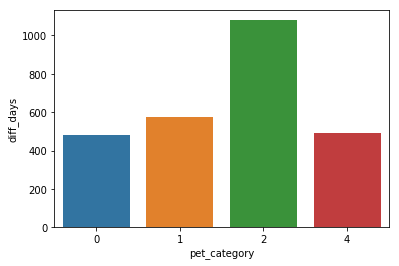

In [145]:
sns.barplot(data=dataC.groupby(['pet_category'],as_index=False).agg({'diff_days':np.mean}),x="pet_category",y="diff_days")

 We can see that difference between issue date and listing date gives us a clear ditinction in the pet category

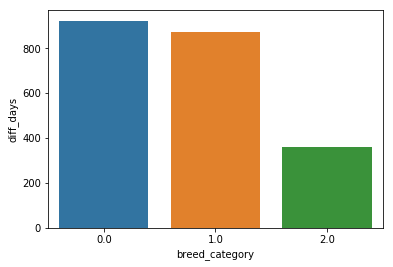

In [146]:
sns.barplot(data=dataC.groupby(['breed_category'],as_index=False).agg({'diff_days':np.mean}),x="breed_category",y="diff_days")

Diff_days plays a vital role in identifying the breed category too

In [147]:
plotdata=dataC.groupby(['pet_category','breed_category'],as_index=False).agg({'diff_days':np.mean})

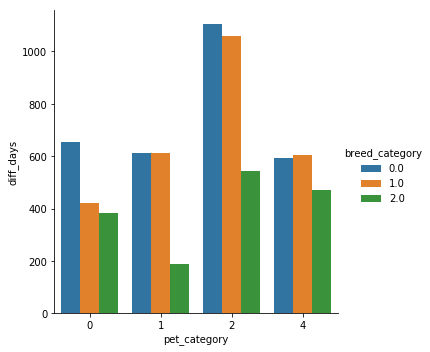

In [148]:
sns.catplot(data=plotdata,x="pet_category",y="diff_days",hue="breed_category",kind="bar")

Within each category difference of days clearly shows a non linera relationship.

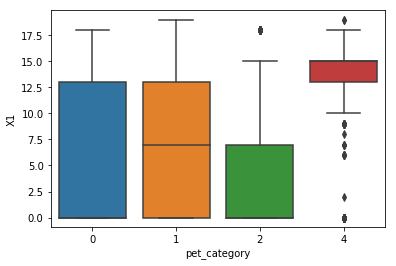

In [149]:
sns.boxplot(data=dataC,x="pet_category",y="X1")

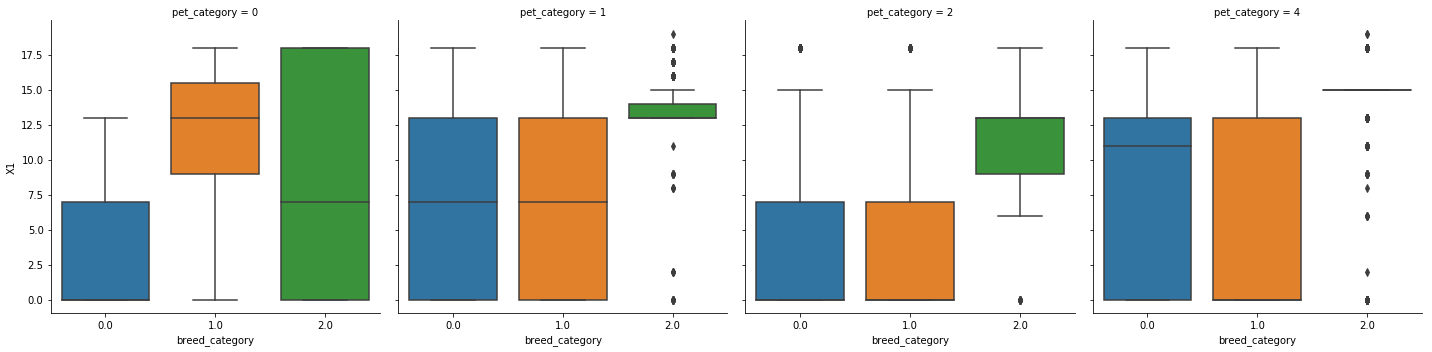

In [150]:
sns.catplot(data=dataC,col="pet_category",y="X1",x="breed_category",kind="box")

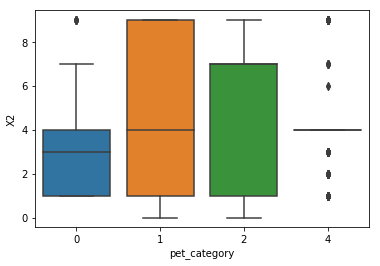

In [151]:
sns.boxplot(data=dataC,x="pet_category",y="X2")

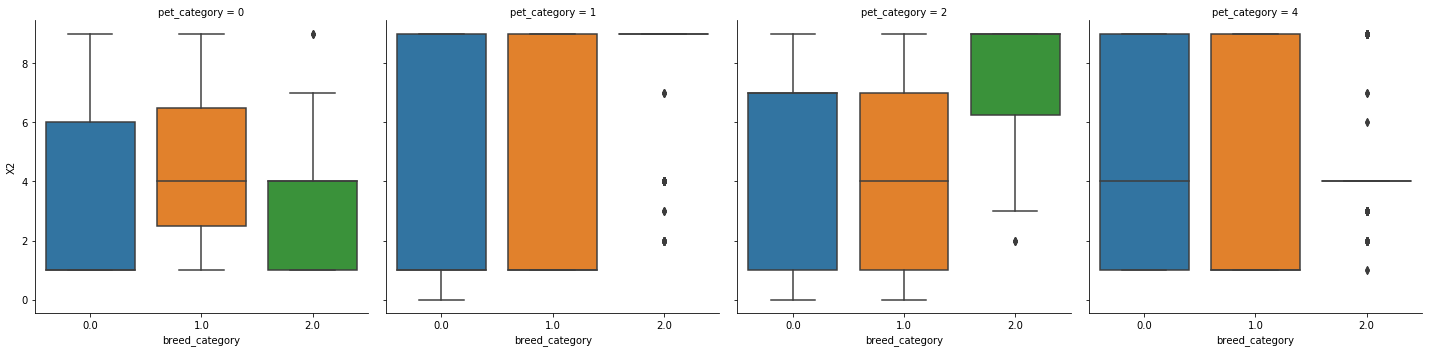

In [152]:
sns.catplot(data=dataC,col="pet_category",y="X2",x="breed_category",kind="box")

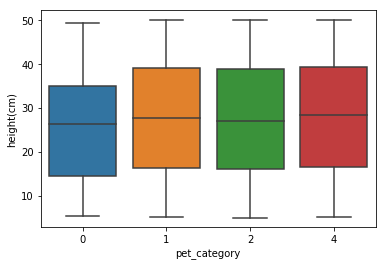

In [153]:
sns.boxplot(data=dataC,x="pet_category",y='height(cm)')

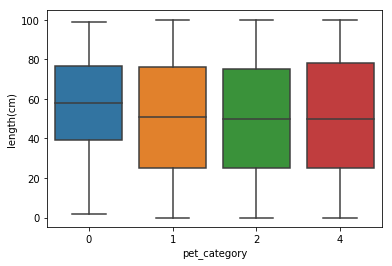

In [154]:
sns.boxplot(data=dataC,x="pet_category",y='length(cm)')

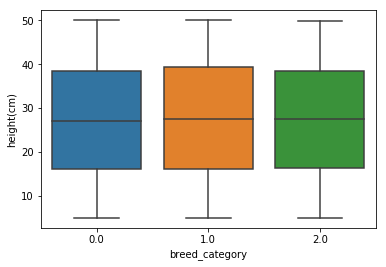

In [155]:
sns.boxplot(data=dataC,x="breed_category",y='height(cm)')

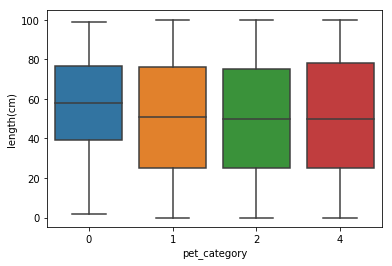

In [156]:
sns.boxplot(data=dataC,x="pet_category",y='length(cm)')

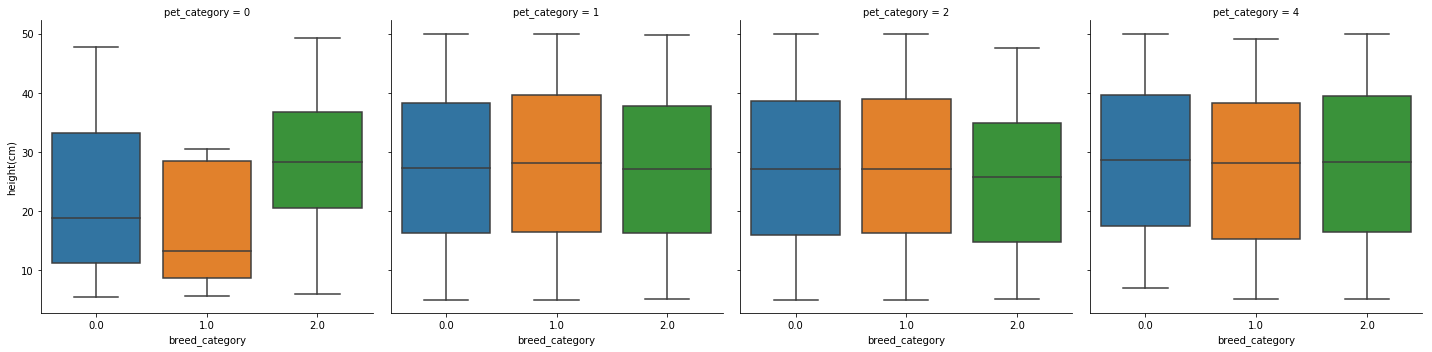

In [157]:
sns.catplot(data=dataC,col="pet_category",y="height(cm)",x="breed_category",kind="box")

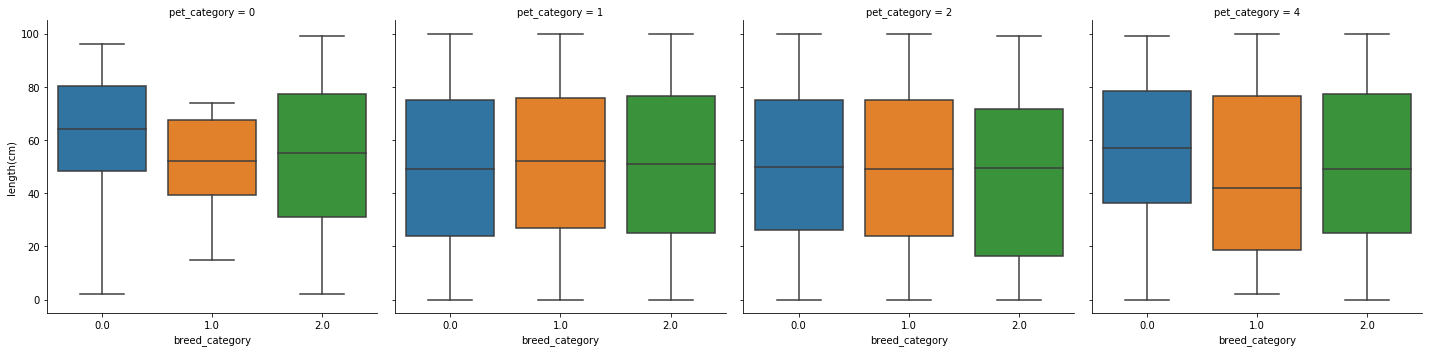

In [158]:
sns.catplot(data=dataC,col="pet_category",y="length(cm)",x="breed_category",kind="box")

We can see that height and length do not help in finding the pet category and there are few datapoints with 0 as length. We can try to find the ratio between height and length and try to find any insights.

In [159]:
dataC.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category,diff_days,length(cm)
count,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.951736,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143,855.306786,50.263566
std,0.795007,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919,1096.674990,28.870505
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,-76.000000,0.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000,119.000000,25.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000,392.000000,50.000000
75%,2.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000,1117.000000,76.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000,8056.000000,100.000000


50% of the data has 0 as length we can fill that with the lower quantile value or else it would be difficult to formulate a new feature from it.

In [160]:
dataC[dataC['length(cm)']==0].size

1209

In [161]:
value=dataC['length(cm)'].quantile(q=0.25)
dataC['length(cm)'] = dataC['length(cm)'].replace(to_replace=0, value=value)

In [162]:
dataC.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category,diff_days,length(cm)
count,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.951736,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143,855.306786,50.387013
std,0.795007,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919,1096.674990,28.708304
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,-76.000000,1.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000,119.000000,25.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000,392.000000,50.000000
75%,2.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000,1117.000000,76.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000,8056.000000,100.000000


In [163]:
dataC['Ratio_HL']=dataC['length(cm)']/dataC['height(cm)']

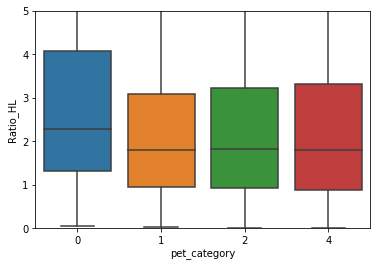

In [164]:
#plt.figure(figsize=(15,10))
plt.ylim(0, 5)
sns.boxplot(data=dataC,x='pet_category',y='Ratio_HL')

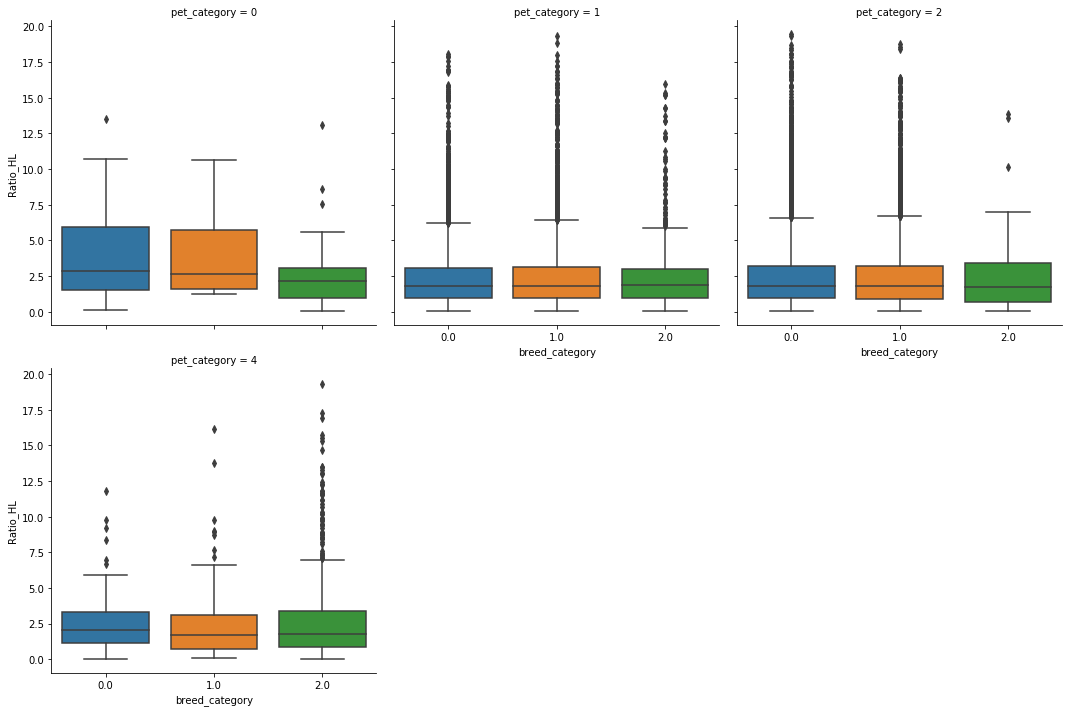

In [165]:
sns.catplot(data=dataC,col="pet_category",y="Ratio_HL",x="breed_category",kind="box",col_wrap=3)

Instead of using the length we have created a new feature combining the length and height and using this feature we can see it shows diffenent values for each category this may play a vital role

In [166]:
dataC.groupby(['color_type','pet_category','breed_category'],as_index=False).size()

color_type      pet_category  breed_category
Agouti          2             0.0                  1
                              1.0                  1
                4             1.0                  1
                              2.0                  1
Apricot         2             0.0                  6
                              1.0                  7
Black           0             0.0                 12
                              1.0                  2
                              2.0                  2
                1             0.0                867
                              1.0                673
                              2.0                141
                2             0.0               1471
                              1.0               1242
                              2.0                 17
                4             0.0                 17
                              1.0                 13
                              2.0                163
B

We can see that major color type represents the pet and breed category so this featue might be useful.

In [167]:
dataC.groupby('pet_category').size()

pet_category
0       88
1     7184
2    10621
4      941
dtype: int64

We can see the date is skewed we'll handle this later as this may affect the model training

In [168]:
dataC.groupby(['pet_category','breed_category']).size()

pet_category  breed_category
0             0.0                 30
              1.0                  7
              2.0                 51
1             0.0               3195
              1.0               3406
              2.0                583
2             0.0               5692
              1.0               4869
              2.0                 60
4             0.0                 83
              1.0                 75
              2.0                783
dtype: int64

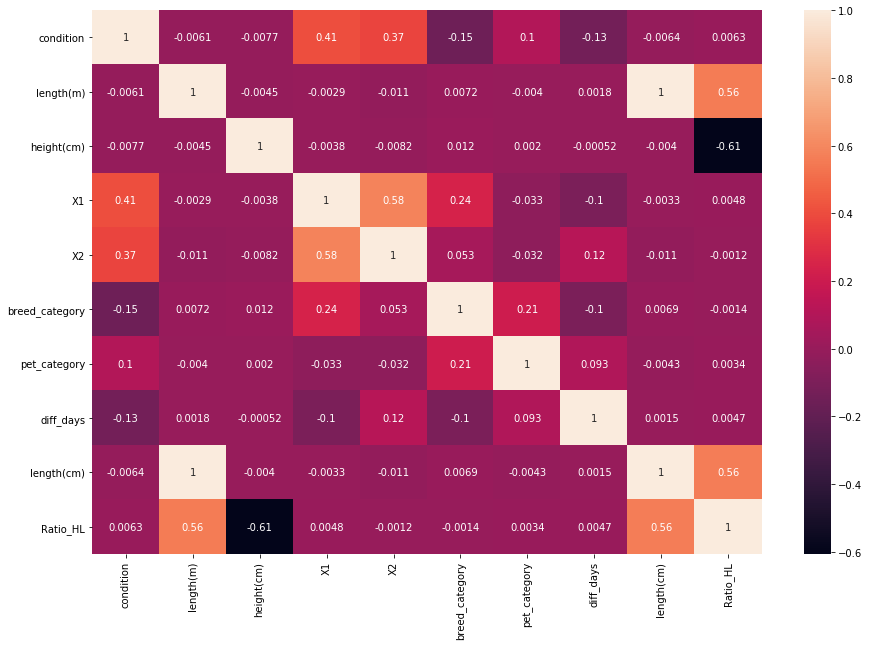

In [169]:
plt.figure(figsize=(15,10))
sns.heatmap(dataC.corr(),annot=True)

As we can see some correlatin with X1 and X2 we can try to find out any relationship amoung the targets and with some combination of X1 and X2

In [170]:
dataC['X1-X2']=dataC['X1']-dataC['X2']


dataC['X1*X2']=dataC['X1']*dataC['X2']
dataC['X1/X2']=dataC['X1']/dataC['X2']

dataC['X1+X2']=dataC['X2']+dataC['X1']

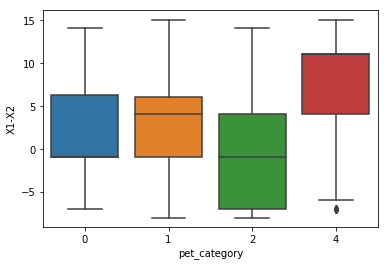

In [171]:
sns.boxplot(data=dataC,y='X1-X2',x='pet_category')

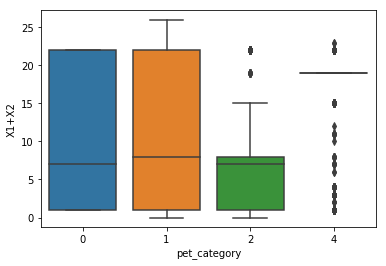

In [172]:
sns.boxplot(data=dataC,y='X1+X2',x='pet_category')

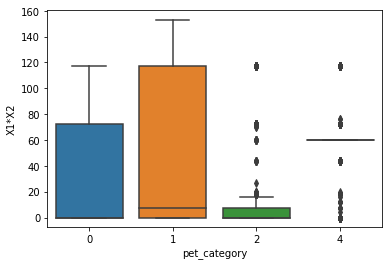

In [173]:
sns.boxplot(data=dataC,y='X1*X2',x='pet_category')

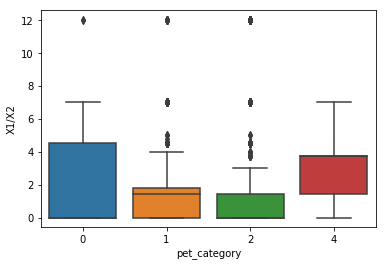

In [174]:
sns.boxplot(data=dataC,y='X1/X2',x='pet_category')

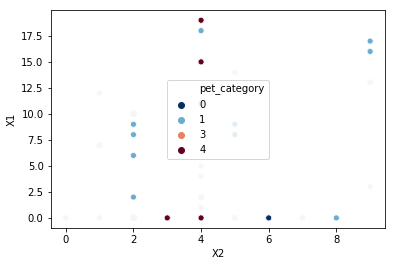

In [175]:

ax=sns.scatterplot(data=dataC,y='X1',x='X2',hue='pet_category',palette='RdBu_r')

In [176]:
dataC.drop(columns=['X1-X2','X1*X2','X1+X2','X1/X2'],inplace=True)

In [177]:
dataC.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,diff_days,length(cm),Ratio_HL
0,ANSL_69903,2016-07-10,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1,73,80.0,10.282776
1,ANSL_66892,2013-11-21,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2,1862,72.0,5.073996
2,ANSL_69750,2014-09-28,2016-10-19 08:24:00,2.0,Brown,0.15,40.90,15,4,2.0,4,752,15.0,0.366748
3,ANSL_71623,2016-12-31,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2,755,62.0,3.479237
4,ANSL_57969,2017-09-28,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1,52,50.0,4.520796


In [178]:
def preprocessing(df,status):
    if(status=='train'):
        y=df['pet_category']
        X=df.drop(columns='pet_category')
        oversample=RandomOverSampler() # here oversampler is used to handle to skew dataset
        over_X,over_y=oversample.fit_resample(X,y)
        sampled_data=over_X
        sampled_data['pet_category']=over_y
    else:
        sampled_data=df
        value=sampled_data['length(cm)'].quantile(q=0.25)
        sampled_data['length(cm)'] = sampled_data['length(cm)'].replace(to_replace=0, value=value)
        sampled_data['Ratio_HL']=sampled_data['length(cm)']/dataC['height(cm)']

        
    
    data=sampled_data.drop(columns=['pet_id','issue_date','listing_date','length(m)','height(cm)',
                     'length(cm)']) # unneccesary features are deleted
    encoder=ce.OneHotEncoder(cols='condition')
    data=encoder.fit_transform(data) # encoding the category variable
    
    encoder1=ce.BinaryEncoder(cols='color_type')
    data=encoder1.fit_transform(data) # encoding category variable

    return data
    

In [179]:
processed=preprocessing(dataC,status='train')
processed.head()

,condition_1,condition_2,condition_3,color_type_0,color_type_1,color_type_2,color_type_3,color_type_4,color_type_5,color_type_6,X1,X2,breed_category,diff_days,Ratio_HL,pet_category
0,1,0,0,0,0,0,0,0,0,1,13,9,0.0,73,10.282776,1
1,0,1,0,0,0,0,0,0,1,0,13,9,0.0,1862,5.073996,2
2,1,0,0,0,0,0,0,0,1,1,15,4,2.0,752,0.366748,4
3,0,1,0,0,0,0,0,0,1,0,0,1,0.0,755,3.479237,2
4,1,0,0,0,0,0,0,1,0,0,18,4,0.0,52,4.520796,1


In [180]:
processed.groupby('pet_category').size()

pet_category
0    10621
1    10621
2    10621
4    10621
dtype: int64

In [181]:
y=processed[['pet_category','breed_category']]
X=processed.drop(columns=['pet_category','breed_category'])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=400)

In [182]:
clf=RandomForestClassifier(n_estimators=100)

In [183]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [184]:
def evaluation(clf,X_test,y_test):
    # a common evaluation method is made to get the metric for each model easily
    # along with the metrics it displays the confusion matrix 
    #[[00,01]
    #[10,11]]
    # where 00 - is the count of havig both pet and breed correctly identified
    # 01 - count of breed wrongly predicted
    #10 -count of pet wrongly perdicted 
    #11 - both pet and breed wrongly predicted
    
    y_pred=clf.predict(X_test)
    y_eval=y_test.copy()
    
    y_eval['pet_category_predicted']=y_pred[:,0]
    y_eval['breed_category_predicted']=y_pred[:,1]
    
    y_eval['breed_category_eval']=y_eval[['breed_category','breed_category_predicted']].apply(lambda x :0 if x['breed_category']==x['breed_category_predicted'] else 1,axis=1)
    y_eval['pet_category_eval']=y_eval[['pet_category','pet_category_predicted']].apply(lambda x :0 if x['pet_category']==x['pet_category_predicted'] else 1,axis=1)
    
    return (
            print(metrics.classification_report(y_eval['pet_category'],y_eval['pet_category_predicted'])),
            print(metrics.classification_report(y_eval['breed_category'],y_eval['breed_category_predicted'])),
            print('accuracy for pet category',metrics.accuracy_score(y_eval['pet_category'],y_eval['pet_category_predicted'])),
            print('accuracy for breed category',metrics.accuracy_score(y_eval['breed_category'],y_eval['breed_category_predicted'])),
            print(metrics.confusion_matrix(y_eval['pet_category_eval'],y_eval['breed_category_eval']))
            )



In [185]:
evaluation(clf,X_test,y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2084
           1       0.92      0.92      0.92      2176
           2       0.92      0.89      0.91      2093
           4       0.98      1.00      0.99      2144

    accuracy                           0.95      8497
   macro avg       0.95      0.95      0.95      8497
weighted avg       0.95      0.95      0.95      8497

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      2975
         1.0       0.92      0.92      0.92      2341
         2.0       0.98      0.98      0.98      3181

    accuracy                           0.95      8497
   macro avg       0.95      0.95      0.95      8497
weighted avg       0.95      0.95      0.95      8497

accuracy for pet category 0.9541014475697305
accuracy for breed category 0.9513946098623044
[[7750  357]
 [ 334   56]]


(None, None, None, None, None)

In [186]:
clf1=RandomForestClassifier(n_estimators=80)
clf1.fit(X_train,y_train)
evaluation(clf=clf1,X_test=X_test,y_test=y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2084
           1       0.92      0.92      0.92      2176
           2       0.92      0.90      0.91      2093
           4       0.98      1.00      0.99      2144

    accuracy                           0.96      8497
   macro avg       0.96      0.96      0.96      8497
weighted avg       0.95      0.96      0.95      8497

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      2975
         1.0       0.92      0.92      0.92      2341
         2.0       0.98      0.98      0.98      3181

    accuracy                           0.95      8497
   macro avg       0.95      0.95      0.95      8497
weighted avg       0.95      0.95      0.95      8497

accuracy for pet category 0.9551606449335059
accuracy for breed category 0.9512769212663293
[[7762  354]
 [ 321   60]]


(None, None, None, None, None)

In [187]:
#mod=GridSearchCV(clf,param_grid={'n_estimators':[x for x in range(60,250,10)]})
#mod.fit(X_train,y_train)
#mod.best_estimator_

In [188]:
feature_imp=pd.Series(clf1.feature_importances_,index=X.columns)
feature_imp.sort_values(ascending=False)

diff_days       0.202935
Ratio_HL        0.149194
X1              0.116936
X2              0.105639
condition_2     0.087219
condition_1     0.086199
condition_3     0.080624
color_type_5    0.040099
color_type_6    0.037879
color_type_3    0.032412
color_type_4    0.029467
color_type_2    0.023282
color_type_1    0.008116
color_type_0    0.000000
dtype: float64

In [189]:
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [190]:
actual_test=pd.read_csv('test.csv')
actual_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [191]:
actual_test.isna().sum()

pet_id            0
issue_date        0
listing_date      0
condition       619
color_type        0
length(m)         0
height(cm)        0
X1                0
X2                0
dtype: int64

In [192]:
test_data=preprocessing(FillingNa(actual_test,status='test'),status='test')

D:\ProgramFiles\anaconda3\envs\nlp_course\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
D:\ProgramFiles\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [193]:
test_data.isna().sum()

condition_1     0
condition_2     0
condition_3     0
color_type_0    0
color_type_1    0
color_type_2    0
color_type_3    0
color_type_4    0
color_type_5    0
color_type_6    0
X1              0
X2              0
diff_days       0
Ratio_HL        0
dtype: int64

In [194]:
test_data.head()

,condition_1,condition_2,condition_3,color_type_0,color_type_1,color_type_2,color_type_3,color_type_4,color_type_5,color_type_6,X1,X2,diff_days,Ratio_HL
0,1,0,0,0,0,0,0,0,0,1,0,7,4404,11.182519
1,0,1,0,0,0,0,0,0,1,0,0,1,174,0.422833
2,0,1,0,0,0,0,0,0,0,1,0,7,1999,0.586797
3,0,1,0,0,0,0,0,0,0,1,7,1,1148,1.627385
4,0,1,0,0,0,0,0,0,1,1,0,7,463,6.419530


In [195]:
predictions=clf.predict(test_data)

In [196]:
actual_test['pet_category']=predictions[:,0]
actual_test['breed_category']=predictions[:,1]
actual_test.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,diff_days,length(cm),Ratio_HL,pet_category,breed_category
0,ANSL_75005,2005-08-17,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7,4404,87.0,11.182519,2.0,0.0
1,ANSL_76663,2018-11-15,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1,174,6.0,0.422833,2.0,0.0
2,ANSL_58259,2012-10-11,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7,1999,24.0,0.586797,1.0,0.0
3,ANSL_67171,2015-02-13,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1,1148,29.0,1.627385,1.0,0.0
4,ANSL_72871,2017-01-18,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7,463,71.0,6.419530,2.0,0.0


In [197]:
actual_test[['pet_id','pet_category','breed_category']].to_csv('predictions.csv')